In [50]:
from utils import ModelImporter, Preprocessing
import torch
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import time


In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
%reload_ext autoreload

In [53]:
#load data
pre = Preprocessing('fer2013')
pre.load_data(filename='train_reduced_norm.csv', name='train')

X_df = pre.get(name='train').drop(columns=['emotion'])
y_df = pre.get(name='train')['emotion']

In [54]:
from models import CnnSimple
from train import TrainClassifier2

In [55]:
dtype = torch.float
device = torch.device("cpu")

n_classes = 7
n_epochs = 11
learning_rate = 0.001
batch_size = 64

In [56]:
model_name = f'cnn_simple_reduced_{learning_rate}_{batch_size}_{n_epochs}_{n_classes}'
model = CnnSimple(model_name, d_out=n_classes)
model.train()

CnnSimple(
  (drop_hidden): Dropout(p=0.5)
  (drop_visible): Dropout(p=0.2)
  (conv1): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8640, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=7, bias=True)
)

In [57]:
train_classifier = TrainClassifier2(model, X_df, y_df)
t = time.time()
trained_model , optimizer, criterion,\
train_loss_hist, train_acc_hist, train_f1_hist, train_b_hist,\
val_loss_hist, val_acc_hist, val_f1_hist, val_b_hist = train_classifier.run_train(n_epochs = n_epochs,
                                                                      lr=learning_rate,
                                                                      batch_size=batch_size)


use cuda: False
training model: cnn_simple_Reduced_0.001_64_10_7
..........
0 loss t:1.929 v: 1.955 | acc t: 0.2321 v: 0.213 | f1 t: 0.193 v: 0.153 | b t: 0.299 v: 0.220
..........................................................................................
 ####training finished####
optimal iteration val_loss: 0
optimal iteration val_acc: 0
optimal iteration val_f1: 0
optimal iteration val_balanced_score: 0


In [58]:
outputs_val = train_classifier.model(train_classifier.validation_set.x_data.to(train_classifier.device))

In [59]:
accuracy_val= (outputs_val.argmax(1) == train_classifier.validation_set.y_data.to(train_classifier.device)).float().mean()

In [60]:
accuracy_val

tensor(0.2129)

In [61]:
y_true = train_classifier.validation_set.y_data
y_pred = outputs_val.argmax(1)

In [ ]:
metrics.f1_score()

In [62]:
pre.load_data(filename='test_public_norm.csv', name='test')

X_test_df = pre.get(name='test').drop(columns=['emotion'])
y_test_df = pre.get(name='test')['emotion']

In [78]:
from data import Fer2013Dataset
from utils import Metrics

In [69]:
test_dataset = Fer2013Dataset(inputs=X_test_df, targets=y_test_df, device='cpu')

In [70]:
test_prb = train_classifier.model(test_dataset.x_data.to(train_classifier.device))

In [75]:
test_pred = test_prb.argmax(1)

In [76]:
accuracy_test = (test_pred == test_dataset.y_data.to('cpu')).float().mean()
accuracy_test


tensor(0.2134)

In [89]:
labels = train_classifier.labels

In [90]:
test_metrics = Metrics(test_dataset.y_data, test_pred, labels)

In [91]:
test_metrics.balanced_score()

0.2309382283482905

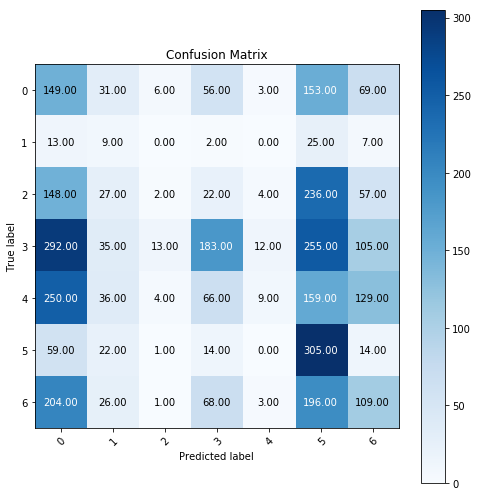

In [98]:
plt = test_metrics.represent_cm()
plt.show()

In [84]:
from sklearn import metrics
labels_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
labels_num = [0, 1, 2, 3, 4, 5, 6]
cm = metrics.confusion_matrix(test_dataset.y_data, test_pred, labels_num)
cm

array([[149,  31,   6,  56,   3, 153,  69],
       [ 13,   9,   0,   2,   0,  25,   7],
       [148,  27,   2,  22,   4, 236,  57],
       [292,  35,  13, 183,  12, 255, 105],
       [250,  36,   4,  66,   9, 159, 129],
       [ 59,  22,   1,  14,   0, 305,  14],
       [204,  26,   1,  68,   3, 196, 109]])

In [86]:
cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

array([[0.32, 0.07, 0.01, 0.12, 0.01, 0.33, 0.15],
       [0.23, 0.16, 0.  , 0.04, 0.  , 0.45, 0.12],
       [0.3 , 0.05, 0.  , 0.04, 0.01, 0.48, 0.11],
       [0.33, 0.04, 0.01, 0.2 , 0.01, 0.28, 0.12],
       [0.38, 0.06, 0.01, 0.1 , 0.01, 0.24, 0.2 ],
       [0.14, 0.05, 0.  , 0.03, 0.  , 0.73, 0.03],
       [0.34, 0.04, 0.  , 0.11, 0.  , 0.32, 0.18]])

In [92]:
cm.shape

(7, 7)

In [93]:
val = 0.0
for i in range(cm.shape[0]):
    print(i)
    val += cm[i, i]


0
1
2
3
4
5
6


In [95]:
val/cm.shape[0]

0.2309382283482905

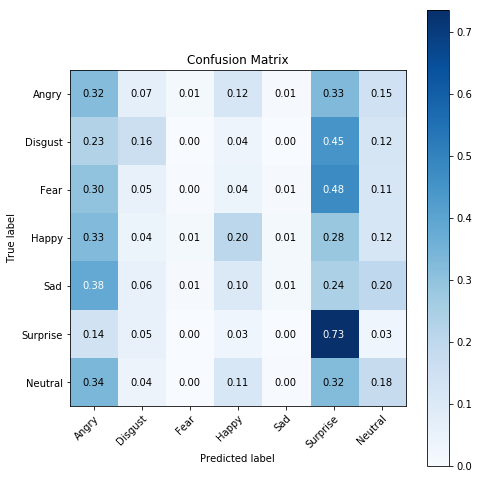

In [85]:
np.set_printoptions(precision=2)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

